In [1]:
import seaborn as sns
import pandas as pd
from ctgan import CTGAN
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
wallets_features = pd.read_csv("../dataset/custom/train_test_split/wallets_features_aggregated__train.csv")
wallets_features.head()

,class,num_timesteps_appeared_in,fees_median,num_addr_transacted_multiple,addrId,userId,user_ts_fees_share_mean,user_ts_fees_share_min,user_ts_fees_share_max,user_addr_cnt,...,btc_sent_min,btc_received_min,fees_min,transacted_w_address_min,btc_transacted_max,btc_sent_max,btc_received_max,fees_max,last_block_appeared_in,transacted_w_address_max
0,1,1.0,0.000037,0.0,1LUwMvFBLBpofVFmFpZE6GLu2Bt6dmE9t3,509812,0.101106,0.101106,0.101106,1,...,0.00000,0.0,0.000037,1.0,0.17695,0.07725,0.17695,0.000217,433546.0,1.0
1,1,1.0,0.000040,0.0,17fuBJ5qquYF6VTX8n19t9yccp95vWEVME,331400,0.194991,0.194991,0.194991,4,...,0.00026,0.0,0.000040,1.0,0.00026,0.00026,0.00000,0.000040,395236.0,1.0
2,1,1.0,0.000040,0.0,1CQ77ewS2smh8aBP3pahuVEt67ga3YWvL9,331400,0.194991,0.194991,0.194991,4,...,0.00200,0.0,0.000040,1.0,0.00200,0.00200,0.00000,0.000040,395236.0,1.0
3,1,1.0,0.000040,0.0,1EhTXo5svU9SJvk6ZvmKnFQwVDo6a5tKH2,331400,0.194991,0.194991,0.194991,4,...,0.00220,0.0,0.000040,1.0,0.00220,0.00220,0.00000,0.000040,395236.0,1.0
4,1,1.0,0.000040,0.0,1GP4t8rAiZJ7wAcYZLL8f5sm9vdvUU9tUu,331400,0.194991,0.194991,0.194991,4,...,0.00178,0.0,0.000040,1.0,0.00178,0.00178,0.00000,0.000040,395236.0,1.0


In [4]:
wallets_features.columns

Index(['class', 'num_timesteps_appeared_in', 'fees_median',
       'num_addr_transacted_multiple', 'addrId', 'userId',
       'user_ts_fees_share_mean', 'user_ts_fees_share_min',
       'user_ts_fees_share_max', 'user_addr_cnt', 'user_outcoming_tx_cnt',
       'user_incoming_tx_cnt', 'user_input_users_cnt', 'user_output_users_cnt',
       'user_active_time_steps_cnt', 'user_btc_sent_total',
       'user_btc_received_total', 'user_interracted_output_address_cnt',
       'user_interracted_input_address_cnt', 'user_overall_activity_coef',
       'user_whole_fee_5', 'addr_gini', 'whole_fees_5', 'num_txs_as_sender',
       'num_txs_as receiver', 'lifetime_in_blocks', 'total_txs',
       'btc_transacted_total', 'btc_sent_total', 'btc_received_total',
       'fees_total', 'transacted_w_address_total', 'first_block_appeared_in',
       'first_sent_block', 'first_received_block', 'btc_transacted_min',
       'btc_sent_min', 'btc_received_min', 'fees_min',
       'transacted_w_address_min', 'btc

In [67]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit_transform(prepare_wallets_features_for_gan(wallets_features_licit))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.03332472e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.53846154e-01, 1.67647179e-03, 2.48447205e-03, ...,
        6.71320776e-03, 9.58326014e-01, 4.44444444e-02],
       [6.92307692e-01, 1.67647179e-03, 4.34782609e-03, ...,
        2.02775410e-02, 9.99938001e-01, 2.22222222e-02],
       [1.00000000e+00, 2.05188971e-03, 1.43478261e-01, ...,
        5.81970865e-01, 7.91671403e-01, 1.55555556e-01]])

In [36]:
wallets_features_licit = wallets_features[wallets_features["class"] == 2]
wallets_features_illicit = wallets_features[wallets_features["class"] == 1]

wallets_features_licit.shape, wallets_features_illicit.shape

((81867, 46), (10067, 46))

In [ ]:
def prepare_wallets_features_for_gan(df):
    return df \
        .drop([
            "class", "addrId", "userId",
            'user_ts_fees_share_mean', 'user_ts_fees_share_min',
            'user_ts_fees_share_max', 'user_addr_cnt', 'user_outcoming_tx_cnt',
            'user_incoming_tx_cnt', 'user_input_users_cnt', 'user_output_users_cnt',
            'user_active_time_steps_cnt', 'user_btc_sent_total',
            'user_btc_received_total', 'user_interracted_output_address_cnt',
            'user_interracted_input_address_cnt', 'user_overall_activity_coef',
            'user_whole_fee_5', "last_block_appeared_in"
        ], axis=1)

In [ ]:
ctgan = CTGAN(
    epochs=100,
    verbose=True,
    embedding_dim=256,
    generator_dim=(256, 512, 256),
)
ctgan.fit(
    prepare_wallets_features_for_gan(wallets_features_licit),
)


Gen. (-0.21) | Discrim. (0.37): 100%|██████████| 100/100 [07:15<00:00,  4.35s/it]


In [85]:
# torch.save(ctgan, "./ctgan_wallets_300.pth")
ctgan = torch.load("./model.pth")

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/945221793.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ctgan = torch.load("./model.pth")
/Users/yegor

AttributeError: Can't get attribute 'Generator' on <module '__main__'>

In [59]:
ctgan._generator

Generator(
  (seq): Sequential(
    (0): Residual(
      (fc): Linear(in_features=128, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Residual(
      (fc): Linear(in_features=384, out_features=256, bias=True)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): Linear(in_features=640, out_features=147, bias=True)
  )
)

In [56]:
import torch.nn.functional as F

def vec_to_df(vec):
    return pd.DataFrame({
        "sepal_length": [vec[0]],
        "sepal_width": [vec[1]],
        "petal_length": [vec[2]],
        "petal_width": [vec[3]],
        
    })

def detect_anomaly(vec, vec_df):
    ctgan._generator.eval()
    ctgan._discriminator.eval()

    mean = torch.zeros(2, ctgan._embedding_dim)
    std = mean + 1
    z = torch.normal(mean=mean, std=std).to(ctgan._device)
    z.requires_grad = True
    optimizer = torch.optim.Adam([z], lr=1 * 1e-2)
    # print(z.shape)

    features_real = {}
    features_fake = {}

    feats_hist = []

    def hook_real(module, input, output):
        features_real['feat'] = output
        feats_hist.append(output)

    def hook_fake(module, input, output):
        features_fake['feat'] = output
        feats_hist.append(output)

    # Attach hooks to a middle layer in D (assumes sequential model)
    layer = list(list(ctgan._discriminator.children())[0].children())[-3]  # adjust depending on your D architecture
    handle_real = layer.register_forward_hook(hook_real)
    # handle_fake = layer.register_forward_hook(hook_fake)

    # vec_transformed = ctgan._transformer.transform(vec_to_df(vec))
    vec_transformed = ctgan._transformer.transform(vec_df)
    # print(torch.tensor([vec_transformed]).shape)

    vec_transformed_vectorized = torch.cat([
        torch.tensor([vec_transformed]),
    ]*10)
    vec_transformed_vectorized_single = torch.tensor(vec_transformed[0,:])

    # print(vec_transformed_vectorized_single)

    res_losses_hist = []
    loss_hist = []

    STEPS = 2000
    for i in range(STEPS):
        optimizer.zero_grad()

        # print("--=-=-", z)
        fake = ctgan._generator(z)
        # print("--=-=-", fake)
        # return
        fakeact = ctgan._apply_activate(fake)

        fake_vectorized = torch.cat([
            torch.tensor(fakeact),
        ]*10)

        # print(fakeact)

        ctgan._discriminator(vec_transformed_vectorized.type(torch.float))

        ctgan._discriminator(fake_vectorized.type(torch.float))
    
        # transformed = ctgan._transformer.inverse_transform(fakeact)


        # feature_loss = F.l1_loss(features_fake['feat'], features_real['feat'])
        feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
        

        # print(feature_loss)

        # residual_loss = F.l1_loss(torch.tensor(np.array(transformed)[0,:]), torch.tensor(vec))
        residual_loss = F.l1_loss(fake[0,:], vec_transformed_vectorized_single)

        # print("AAAA", len(feats_hist), features_fake['feat'], "\nBBB", features_real['feat'])

        # print("AAAA", len(feats_hist), feats_hist[-1], "\nBBB",  feats_hist[-2])

        # print(residual_loss)

        # Total loss
        loss = residual_loss + 0.1 * feature_loss
        # print(f"Feature loss = {feature_loss.item()}, Residual loss = {residual_loss.item()}, Loss = {loss}")
        loss.backward()
        optimizer.step()

        feats_hist = []

        loss_hist.append(loss.item())

        # print(z[1,:10])

    return loss_hist[-1], loss_hist

# ctgan._discriminator.pac = 1

# score, losses = detect_anomaly(np.array([10000,100,3,-100]))
# sns.lineplot(losses)

In [64]:
prepared_wallets_data = prepare_wallets_features_for_gan(wallets_features_licit).reset_index().drop(columns=["index"])
prepared_wallets_data_illicit = prepare_wallets_features_for_gan(wallets_features_illicit).reset_index().drop(columns=["index"])

licit_scores = []
illicit_scores = []

for i in range(10):
    score, _ = detect_anomaly(
        np.array(prepared_wallets_data)[i,:],
        prepared_wallets_data.iloc[i:i+1,:]
    )
    licit_scores.append(score)

    score_illicit, _ = detect_anomaly(
        np.array(prepared_wallets_data_illicit)[i,:],
        prepared_wallets_data_illicit.iloc[i:i+1,:]
    )
    illicit_scores.append(score_illicit)

    print(f"licit: {score}, illicit: {score_illicit}")

/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.212536081106228, illicit: 4.217072876045581


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.2757728441601985, illicit: 4.20990344203573


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.265977386045087, illicit: 4.224800042210173


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.20122554497762, illicit: 4.235722515266612


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.27671439290448, illicit: 4.242352563653095


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.233416621656716, illicit: 4.24081741199395


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.231509923937974, illicit: 4.211997069912261


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.2336961324176565, illicit: 4.215730758250638


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.214509950970565, illicit: 4.230592934015322


/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:79: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  feature_loss = F.l1_loss(feats_hist[-1], feats_hist[-2])
/var/folders/hj/pbs977kd43s6n1l9z3mxrj200000gn/T/ipykernel_32668/15520238.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(fakeact),
/var/folders/hj/pbs977kd43s6n1l9z3mxr

licit: 4.201823291057954, illicit: 4.26993664944487


<Axes: >

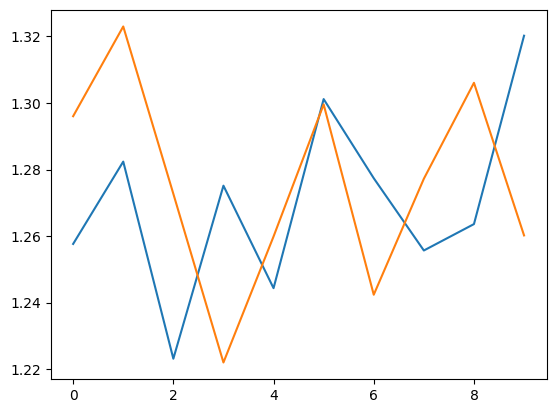

In [58]:
sns.lineplot(licit_scores)
sns.lineplot(illicit_scores)


In [49]:
licit_scores

[1.3188931825465435,
 1.451430539968899,
 1.3614806835927196,
 1.33177850430604,
 1.3981289874554954,
 1.499089222767242,
 1.4229676614319566,
 1.369374338101073,
 1.323741513021462,
 1.2878388777366034]

In [50]:
illicit_scores

[1.3411379238633168,
 1.3863375891523027,
 1.3972368180480585,
 1.338905668560667,
 1.3227125532609014,
 1.3645110058010277,
 1.38093001654687,
 1.5135586193307207,
 1.3819829011613531,
 1.3759380126712866]

In [30]:
# pd.DataFrame(prepared_wallets_data.iloc[0])
prepared_wallets_data.iloc[0:1,:]

,num_timesteps_appeared_in,fees_median,num_addr_transacted_multiple,addr_gini,whole_fees_5,num_txs_as_sender,num_txs_as receiver,lifetime_in_blocks,total_txs,btc_transacted_total,...,btc_sent_min,btc_received_min,fees_min,transacted_w_address_min,btc_transacted_max,btc_sent_max,btc_received_max,fees_max,last_block_appeared_in,transacted_w_address_max
0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.001,...,0.001,0.0,0.0,1.0,0.001,0.001,0.0,0.0,391200.0,1.0


<Axes: ylabel='Generator Loss'>

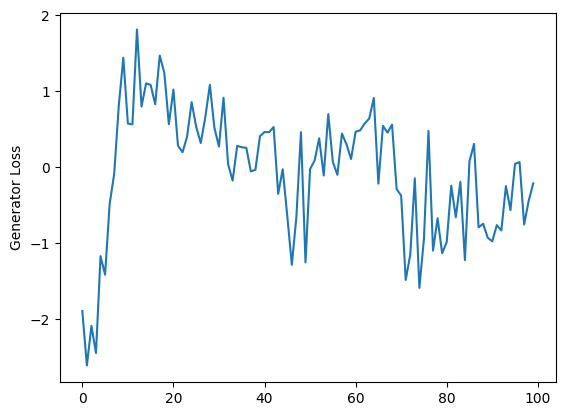

In [62]:
sns.lineplot(ctgan.loss_values["Generator Loss"])


<Axes: ylabel='Discriminator Loss'>

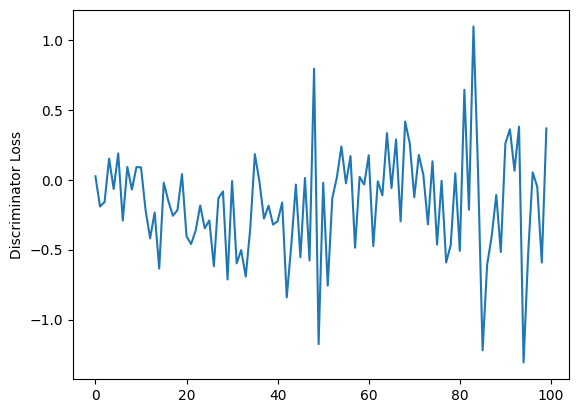

In [63]:
sns.lineplot(ctgan.loss_values["Discriminator Loss"])

In [65]:
ctgan.sample(10)

,num_timesteps_appeared_in,fees_median,num_addr_transacted_multiple,addr_gini,whole_fees_5,num_txs_as_sender,num_txs_as receiver,lifetime_in_blocks,total_txs,btc_transacted_total,...,btc_sent_min,btc_received_min,fees_min,transacted_w_address_min,btc_transacted_max,btc_sent_max,btc_received_max,fees_max,last_block_appeared_in,transacted_w_address_max
0,0.999765,0.002023,-0.001090,0.000335,-0.000349,-3.904722,2.766483,-238.036671,19.675304,83.554483,...,-0.053617,-0.006511,0.002173,1.000309,0.103342,0.013532,0.030626,0.001574,453476.833088,1.001445
1,0.999980,0.002882,0.000591,0.000307,0.998506,7.906769,0.610675,-899.838286,-7.361904,-0.749674,...,0.355678,-0.006639,0.001007,0.999726,0.645316,0.867760,0.317114,0.002814,460843.624838,1.000593
2,0.999293,0.090221,-0.018055,0.000311,0.000750,19.325858,1.857647,-854.438794,16.227356,-9.704921,...,-0.045286,-0.009880,0.090552,0.999994,1.117854,0.715809,0.284030,0.090441,467611.291753,1.002265
3,0.999098,0.010832,-0.017875,0.000380,0.000960,-1.621824,0.270334,-118.674395,0.097085,12.059220,...,-0.012180,0.001331,0.023539,1.000042,0.034795,0.000539,0.013087,0.021668,463068.623432,1.000550
4,1.000244,-0.000762,-0.000738,-0.000231,-0.001792,-5.577079,3.379736,145.691309,-4.995278,47.404585,...,0.004326,-0.001510,0.001867,0.999853,3.707871,0.095239,4.355315,0.002087,395006.483764,0.999461
5,1.000072,0.003257,-0.006286,-0.000161,0.000211,10.945082,-0.229185,167.142562,3.511022,5.101578,...,-0.020074,-0.005102,0.003762,0.999894,0.049571,-0.006257,-0.014769,0.002511,461014.109899,1.002247
6,1.000390,0.002389,0.002537,0.000013,0.000959,0.503370,0.153633,-167.863429,-4.289312,50.002216,...,0.358035,-0.001261,0.002791,1.000039,3.393426,2.679947,-0.009320,0.001770,430149.594037,1.000446
7,0.998901,0.000844,-0.001202,-0.000053,-0.000521,-2.237193,2.791758,81.126560,11.165466,41.448352,...,-0.063318,-0.006865,0.001092,1.000017,0.117666,30.045457,15.136612,0.000794,450678.348770,1.001274
8,1.000180,0.026806,-0.011752,-0.000072,0.000418,8.392089,0.456691,-45.238601,-1.618460,38.292553,...,0.014886,-0.001147,0.010883,0.999756,0.101202,0.081381,0.018701,0.007474,463289.547361,1.000630
9,1.000787,0.006737,-0.000826,0.000144,0.000343,-6.430670,-0.040499,-189.914427,-10.396301,19.788046,...,0.061420,-0.005911,0.002022,1.000219,4.163338,0.006704,0.016985,0.000961,450489.582660,0.999145


<Axes: >

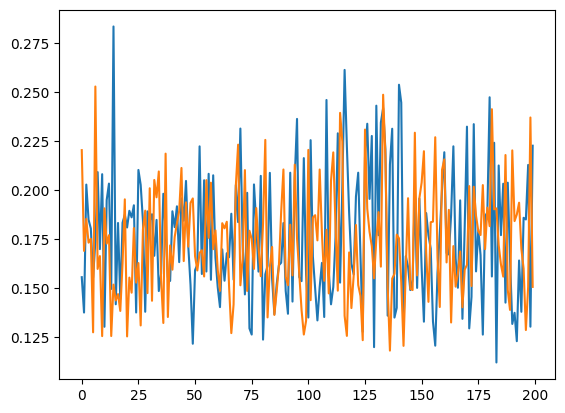

In [ ]:
sns.lineplot(
)
sns.lineplot(

)

In [78]:
licit_scores = np.array([0.15561598939711907, 0.13756289022647344, 0.20288023191209986, 0.18494768783287263, 0.18047135492629934, 0.1554361817106365, 0.1739043699488011, 0.20925816363722138, 0.16992708930737283, 0.2081954127025977, 0.13029874281556536, 0.19502594768002432, 0.20339358925273138, 0.14961322569541807, 0.28360054352118164, 0.14178657419308244, 0.1832901590612327, 0.14441413589211052, 0.18340566047539725, 0.18750435304476762, 0.18098137114084306, 0.18951178007785757, 0.18615045775404312, 0.19232348113019004, 0.1375821685919515, 0.21035989171403802, 0.2027354199532721, 0.18433700902207353, 0.13795954948924632, 0.18921232862349757, 0.18440611193627518, 0.18776787358650687, 0.1665379635807701, 0.1848635294749018, 0.1485411996065213, 0.15732509166290803, 0.19820250156994476, 0.17925090988338588, 0.1555204630278788, 0.1537036322315014, 0.18925963250292088, 0.18115367386018472, 0.1918003254908464, 0.1633022293198726, 0.1958757422905097, 0.18446207491653266, 0.2047558377206891, 0.17162443430774244, 0.15165188349484332, 0.12163840571934662, 0.1592176512789856, 0.16208920340534555, 0.22240133203310336, 0.1572407098560984, 0.20510176148896186, 0.1585070712031218, 0.20838694439528604, 0.15428249802021077, 0.20762387801274118, 0.16564958954133124, 0.1505287740960933, 0.1403420875369275, 0.16980746630010107, 0.1538062164610934, 0.16786512567479162, 0.16575194969732435, 0.188002961134961, 0.15434570770829104, 0.2027111694151078, 0.18371560562379263, 0.23149170229911725, 0.1721301790222078, 0.14680909691680868, 0.19868537113575313, 0.12948542786418055, 0.12632159720966718, 0.20296354711722048, 0.18303656693883896, 0.15846474239661668, 0.20733979569819494, 0.1237371518222002, 0.15710277403140493, 0.16143776715021418, 0.2088783738886823, 0.15481834494427546, 0.13672341335331575, 0.15169761227835224, 0.16170067986181044, 0.16299845991218198, 0.18325279859091914, 0.14867091789182763, 0.13693672806370774, 0.20894062450549747, 0.14315850562373267, 0.20633480098384296, 0.23641361080552517, 0.15568602670755266, 0.15358822775973496, 0.21639802391255245, 0.1571434046989661, 0.1350208213235302, 0.22556324254474436, 0.1660888721254115, 0.1501754833912465, 0.13354363165463173, 0.15068802149900556, 0.16293297200746043, 0.13528804442990042, 0.24607865860589462, 0.1584802241576117, 0.14176346536256146, 0.15064790861299235, 0.17602530569920652, 0.22905803984304948, 0.15284429577539949, 0.2024781589163143, 0.2614263177046658, 0.2224091785240569, 0.18834003928666082, 0.16235518140255822, 0.15705762578985225, 0.19670571339761694, 0.20896116598018377, 0.16649512884890905, 0.12777016026086108, 0.2166751214925831, 0.2339480934663886, 0.1955733646146651, 0.2277083956927256, 0.1198978589093529, 0.24316655485425476, 0.17704619068668193, 0.2345280741776926, 0.24198900439398996, 0.22086741577596364, 0.1359684089935841, 0.2131356384391255, 0.23140214231898076, 0.13500541984647313, 0.13996212980096961, 0.2538610777908062, 0.24470837772331605, 0.13145453575003924, 0.16632804259678652, 0.1609614870592189, 0.1490375145517972, 0.1542187996123433, 0.19962531652562523, 0.15014502192430032, 0.1957218832390188, 0.16019218558395765, 0.13289649440052473, 0.18834968034267463, 0.17694537217781495, 0.1702873966833916, 0.13299217251586015, 0.12065247869170251, 0.15795465876377285, 0.17797004750577872, 0.20038934583291626, 0.21940248121851214, 0.16797059265442132, 0.16722036974920346, 0.18734871755218646, 0.22241710963307693, 0.16526517640656319, 0.15021629925445457, 0.19482290197840066, 0.13435091012696088, 0.18125857796652867, 0.23246011543057404, 0.12946271175725138, 0.14557162531820517, 0.2337377296651077, 0.15856165426290386, 0.17979257050954378, 0.16689664571432872, 0.12630089684378176, 0.18663768861819757, 0.18880299799146094, 0.24745837294737594, 0.1559632012683754, 0.22423794626178634, 0.11207187224014355, 0.2126314306089104, 0.17707205074907784, 0.20332982240934233, 0.1426277624694337, 0.2038527634179546, 0.16509198861587354, 0.1317474303146401, 0.1374250013765434, 0.12293801334419735, 0.16413788414854108, 0.1379429205676324, 0.1859387337675058, 0.18509321834545245, 0.21292873355178746, 0.13034269179602098, 0.22273335146917062])
illicit_scores = np.array(
    [0.22047196163539245, 0.16903033128238915, 0.18534449289963087, 0.17324486680475254, 0.17520688633546136, 0.12747194175901738, 0.2529483456295658, 0.1598366609901664, 0.16638199978382306, 0.1255336550846082, 0.1907577539173232, 0.17272708563317068, 0.17704334688275752, 0.12557626457997306, 0.15182273116401263, 0.14372024428366492, 0.14697799623615543, 0.13838096270971564, 0.1627149258882542, 0.19534984204982947, 0.12537404765239357, 0.15540328015650887, 0.14770647928976055, 0.18068868514963793, 0.15283723772074154, 0.1628373942570645, 0.13097634468058517, 0.18001853813982294, 0.18957565139461263, 0.14747438182218253, 0.20100896444536887, 0.14357426036811116, 0.2052453166334705, 0.19639590920484812, 0.20958926271166756, 0.15459507436235856, 0.13223215905101404, 0.2186866353796181, 0.1352898998100317, 0.17184107149913502, 0.15944237281692844, 0.17613787322480295, 0.1830766062887782, 0.18942908227225608, 0.2113697339896682, 0.16383681488549517, 0.19384180627535205, 0.1712031752484413, 0.19354795054780086, 0.19581487111030565, 0.1663409513194426, 0.15904659837159565, 0.16802373568751738, 0.16935645402823812, 0.15596395883411915, 0.20515790130454564, 0.17569334328477537, 0.20386620465624394, 0.16991798191454988, 0.17950832749340687, 0.15945198816000328, 0.1486425097703135, 0.18318435380215467, 0.1805758650788638, 0.1839221056832236, 0.1512015188497311, 0.1270612918054458, 0.14167748248866924, 0.20249843427317143, 0.2232696277790064, 0.15147637051757498, 0.16487615090703667, 0.21027920565275193, 0.1485844169943119, 0.17931977300127977, 0.17519381734721035, 0.1598380503657596, 0.1908996775481474, 0.17104342902457678, 0.15612238949395452, 0.18283549368703486, 0.22569851458937062, 0.13508348961108899, 0.16089917200519843, 0.17104367072426102, 0.1363398252555802, 0.14818999075327258, 0.1615069986122165, 0.1890825781878405, 0.21059639821799336, 0.15585776539154594, 0.15154412837067172, 0.18240915557818374, 0.15653004505812823, 0.2130657207183071, 0.17549827759602488, 0.15706299066833054, 0.13885793990294, 0.12634210837312498, 0.13336829980265846, 0.2205984941872599, 0.14387612024964885, 0.1861010045900982, 0.1872651602964326, 0.174402682824346, 0.21058040129034514, 0.1776845584690106, 0.1537559734895497, 0.17981129675646623, 0.14733857562841407, 0.2048510997190556, 0.21932846293343405, 0.18133591333201862, 0.14873532374628545, 0.23949566289342925, 0.22483959497516748, 0.135898335298822, 0.1256431067547761, 0.16826089422584806, 0.1398505644960955, 0.1562994366058757, 0.18226459109288773, 0.15161410222812782, 0.146060631279977, 0.12345241014182902, 0.23096947725604636, 0.19055497778916156, 0.17877354002746043, 0.17148331535818648, 0.1550383689025986, 0.1751240215433541, 0.1888215709906635, 0.16099295658544263, 0.24876013995529045, 0.21742374116114083, 0.1508808917471091, 0.11813340322602998, 0.15489650219152515, 0.1573120984876949, 0.1773327131327628, 0.17546793289180607, 0.15293073997404016, 0.12055306639350483, 0.16014495762624703, 0.1959283958274475, 0.14969503225119812, 0.1490459402978816, 0.22936509558411694, 0.15651798094177916, 0.1959621932600487, 0.20397997807122603, 0.21992565029001448, 0.16832053964161983, 0.1430310810250009, 0.18367238873667907, 0.1839844932792311, 0.2270530334915203, 0.16551539063458856, 0.14038778617301706, 0.21044377190969366, 0.2157522167864367, 0.1631483912651948, 0.18999058255519813, 0.1324854100600742, 0.17147640493208308, 0.15076630376530942, 0.1575963750597988, 0.1686913758650475, 0.14023691637173763, 0.15945628218584224, 0.16193200520604323, 0.20211982857849098, 0.1510946923479124, 0.2017897030901598, 0.18697839778410408, 0.17910354207552426, 0.1771281523484023, 0.20263452412759375, 0.16993429605907073, 0.19112017468178555, 0.18166621837085145, 0.24136989879432136, 0.19025724401497546, 0.19074227612008368, 0.17198888275568552, 0.16209742722410642, 0.155913664045429, 0.2179772015830883, 0.14906552381033625, 0.13889630207710646, 0.22034472261865706, 0.18423731650193448, 0.18762243462010791, 0.1936378215689839, 0.17018473045212174, 0.159949392998239, 0.1286295033463805, 0.15071775500708043, 0.23713868343735678, 0.15066124080947418]
)


<Axes: ylabel='Count'>

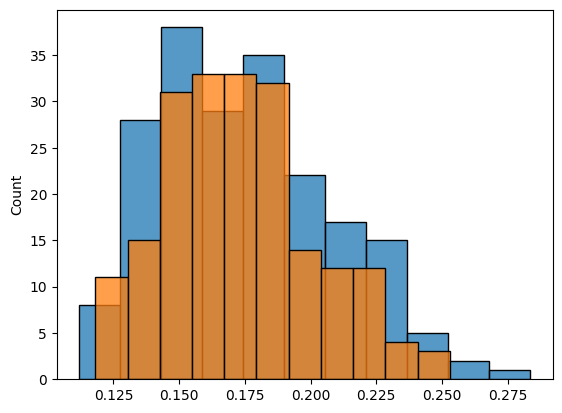

In [79]:
sns.histplot(licit_scores)
sns.histplot(illicit_scores)


In [84]:
thr = 0.16
(licit_scores > thr).sum() / len(licit_scores), (illicit_scores > thr).sum() / len(illicit_scores)

(0.625, 0.62)